**Vibe Matcher**
========================================================
\
This help us to understand the semantic searcch and will help Nexora. I have used GEMINI embedding model for embedding the data and the query, because ChatGPT is no longer providing free credits to any accounts. (Or may be I not able to find out.)

**Enhancment**:
- Ofcourse, intergarting Pinecone or other vector DB for storing the embeddings.
- Handling all types of synonym for vibe tags
- Using best techniques for semantic search

**Why AI at Nexora?**
========================================================
AI at Nexora excites me because it’s exactly where creativity meets data. I’ve already built AI systems like Curio, an AI Co-Teacher that understands voice, vision, and context to assist teachers, and I’ve prototyped intelligent recommendation and matching systems using embeddings, LangGraph, and vector databases, as instructed in the assignment. That experience taught me how to turn vague human inputs into meaningful, ranked results, the same core idea behind Nexora’s vibe-based recommender. I can contribute by designing clean, efficient pipelines for embedding generation, vector search, and GenAI-based refinement, while also analysing performance metrics to keep models fast and accurate. I believe AI can make Nexora’s platform more powerful, and I can contribute to the team from day one.

In [24]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import google.generativeai as genai
from dotenv import load_dotenv
import os
load_dotenv()

GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")
genai.configure(api_key=GEMINI_API_KEY)

In [11]:
products = [
    {"name": "Boho Dress", "desc": "Flowy earthy tones perfect for outdoor festivals", "vibes": ["boho", "free-spirited"]},
    {"name": "Athleisure Hoodie", "desc": "Sleek lightweight hoodie ideal for workouts and city strolls", "vibes": ["sporty", "urban"]},
    {"name": "Denim Jacket", "desc": "Classic rugged denim look for casual street style", "vibes": ["chic", "urban"]},
    {"name": "Silk Saree", "desc": "Elegant traditional attire with gold embroidery", "vibes": ["traditional", "graceful"]},
    {"name": "Graphic Tee", "desc": "Bright colors and bold designs for a youthful street vibe", "vibes": ["energetic", "casual"]},
    {"name": "Knitted Sweater", "desc": "Soft and cozy design, perfect for chilly evenings", "vibes": ["cozy", "comfort"]},
    {"name": "Formal Blazer", "desc": "Sharp and minimal outfit piece for business and meetings", "vibes": ["formal", "chic"]},
    {"name": "Beach Shorts", "desc": "Light fabric with tropical prints for sunny beach days", "vibes": ["casual", "vacation"]},
    {"name": "Leather Boots", "desc": "Bold statement footwear built for durability and confidence", "vibes": ["rugged", "urban"]},
    {"name": "Floral Skirt", "desc": "Colorful and cheerful skirt ideal for spring brunches", "vibes": ["feminine", "boho"]},
]

df = pd.DataFrame(products)
df.head()

,name,desc,vibes
0,Boho Dress,Flowy earthy tones perfect for outdoor festivals,"[boho, free-spirited]"
1,Athleisure Hoodie,Sleek lightweight hoodie ideal for workouts an...,"[sporty, urban]"
2,Denim Jacket,Classic rugged denim look for casual street style,"[chic, urban]"
3,Silk Saree,Elegant traditional attire with gold embroidery,"[traditional, graceful]"
4,Graphic Tee,Bright colors and bold designs for a youthful ...,"[energetic, casual]"


In [ ]:
def get_embedding(text: str) -> np.ndarray:
    try:
        result = genai.embed_content(model="gemini-embedding-001", content=text)
        return np.array(result["embedding"], dtype=float)
    except Exception as e:
        print(f"Embedding error for text: {text[:30]}... | {e}")
        return np.zeros(768)

def cosine_sim(a: np.ndarray, b: np.ndarray) -> float:
    return float(cosine_similarity([a], [b])[0][0])


print("Generating embeddings for products dataframe...")
df["embedding"] = df["desc"].apply(get_embedding)
print("Embeddings ready.\n")

Generating embeddings for products dataframe...
Embeddings ready.



In [19]:
def vibe_matcher(query: str, top_k: int = 3, threshold: float = 0.4) -> pd.DataFrame:
    print(f"Running vibe match: '{query}'")
    query_vec = get_embedding(query)
    df["similarity"] = df["embedding"].apply(lambda emb: cosine_sim(emb, query_vec))
    top_matches = df.sort_values("similarity", ascending=False).head(top_k)
    if top_matches["similarity"].max() < threshold:
        print("Not found.\n")
        return pd.DataFrame()
    top_matches["quality"] = top_matches["similarity"].apply(lambda x: "good" if x > 0.7 else "average")
    return top_matches[["name", "desc", "vibes", "similarity", "quality"]]

test_queries = [
    "energetic urban chic",
    "cozy comfort wear",
    "traditional elegance"
]

latencies, good_match_count = [], 0
results_log = []

for query in test_queries:
    start_time = time.time()
    results = vibe_matcher(query)
    latency = time.time() - start_time
    latencies.append(latency)

    if not results.empty:
        results_log.append((query, results))
        print(f"\nQuery: {query}")
        print(results[["name", "similarity", "quality"]])
    else:
        print(f"\nQuery: {query} → No strong match found.")

good_total = sum(
    (res["quality"] == "good").sum() for _, res in results_log
)
print(f"\nTotal 'good' matches (similarity > 0.7): {good_total}\n")


Running vibe match: 'energetic urban chic'

Query: energetic urban chic
                name  similarity  quality
4        Graphic Tee    0.740484     good
1  Athleisure Hoodie    0.639375  average
0         Boho Dress    0.638853  average
Running vibe match: 'cozy comfort wear'

Query: cozy comfort wear
                name  similarity  quality
5    Knitted Sweater    0.752481     good
1  Athleisure Hoodie    0.637047  average
3         Silk Saree    0.622931  average
Running vibe match: 'traditional elegance'

Query: traditional elegance
              name  similarity  quality
3       Silk Saree    0.749491     good
5  Knitted Sweater    0.664876  average
6    Formal Blazer    0.634900  average

Total 'good' matches (similarity > 0.7): 3



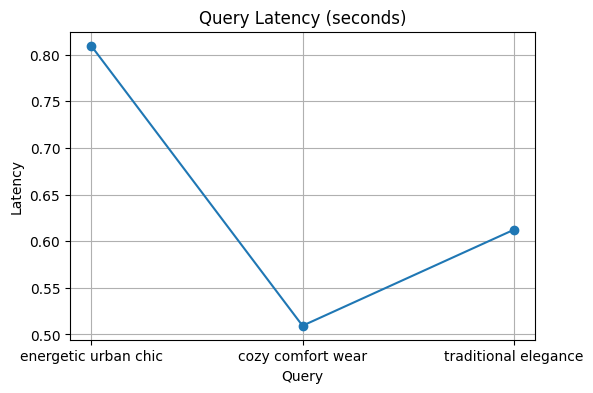

In [20]:
plt.figure(figsize=(6, 4))
plt.plot(test_queries, latencies, marker="o")
plt.title("Query Latency (seconds)")
plt.xlabel("Query")
plt.ylabel("Latency")
plt.grid(True)
plt.show()

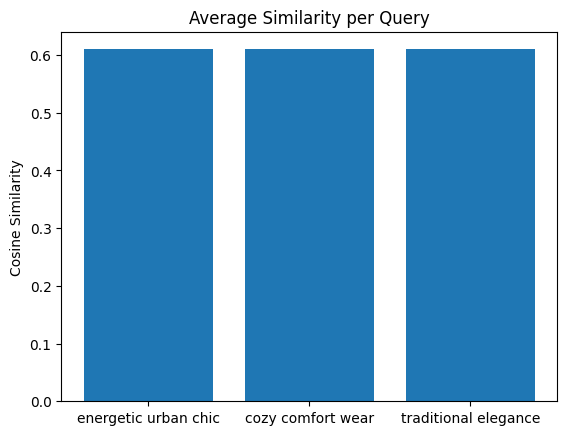

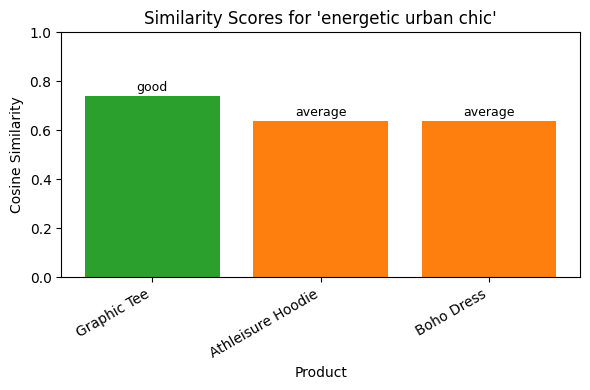

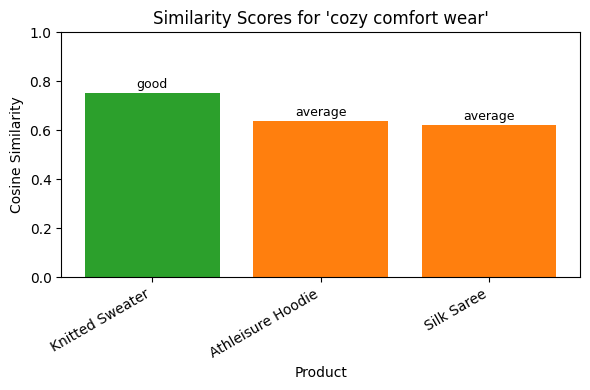

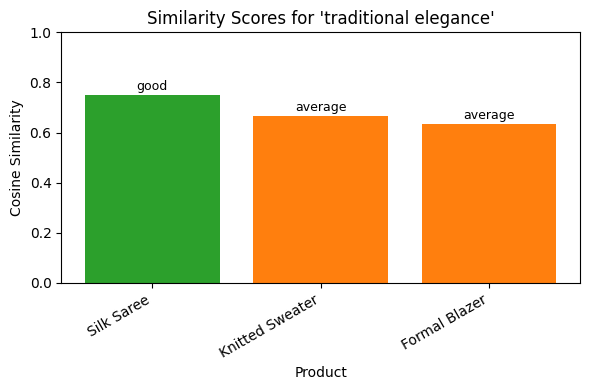

In [22]:
avg_sims = [df["similarity"].mean() for _ in test_queries]
plt.bar(test_queries, avg_sims)
plt.title("Average Similarity per Query")
plt.ylabel("Cosine Similarity")
plt.show()


for query, result in results_log:
    plt.figure(figsize=(6, 4))
    colors = result["quality"].map({"good": "tab:green", "average": "tab:orange"})
    plt.bar(result["name"], result["similarity"], color=colors)
    plt.title(f"Similarity Scores for '{query}'")
    plt.xticks(rotation=30, ha="right")
    plt.xlabel("Product")
    plt.ylabel("Cosine Similarity")
    plt.ylim(0, 1)
    for i, val in enumerate(result["similarity"]):
        plt.text(i, val + 0.02, result["quality"].iloc[i], ha='center', fontsize=9)
    plt.tight_layout()
    plt.show()